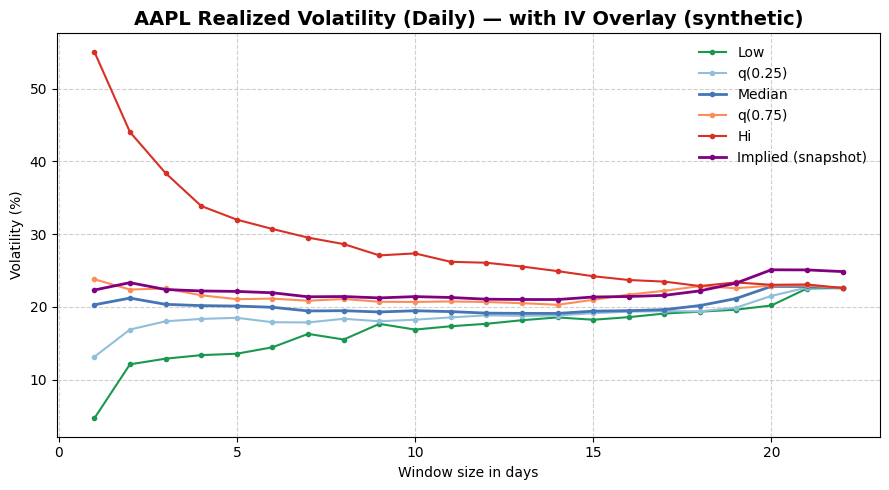

<Axes: title={'center': 'AAPL Realized Volatility (Daily) — with IV Overlay (synthetic)'}, xlabel='Window size in days', ylabel='Volatility (%)'>

In [ ]:
import sys, pandas as pd, numpy as np, importlib
sys.path.append("../src")

import vol_cone
importlib.reload(vol_cone)

# Load + normalize column names like [QUOTE_DATE] -> quote_date
df = pd.read_csv("../data/aapl_eod_202303.csv")
df.columns = [c.strip().strip("[]").lower().replace(" ", "_") for c in df.columns]

# Build a timestamp from quote_date (+ optional quote_time_hours)
if "quote_date" not in df.columns:
    raise ValueError(f"No quote_date column. Got: {df.columns.tolist()}")

ts = pd.to_datetime(df["quote_date"], errors="coerce")
if "quote_time_hours" in df.columns:
    ts = ts + pd.to_timedelta(pd.to_numeric(df["quote_time_hours"], errors="coerce") * 3600, unit="s")
df["__ts"] = ts

# Use mean underlying as the price and keep one value per calendar day
df["close"] = pd.to_numeric(df["underlying_last"], errors="coerce")
daily_close = (
    df.dropna(subset=["__ts", "close"])
      .sort_values("__ts")
      .set_index("__ts")
      .groupby(pd.Grouper(freq="1D"))["close"]
      .mean()
      #.last()
      .dropna()
)
df_daily = pd.DataFrame({"close": daily_close})

# Build realized-vol summary
windows = tuple(range(1, 60))
summary = vol_cone.summarize_realized_vol(df_daily, windows=windows)

# --- Fake an IV curve just to test the overlay ---
# Option A (simple): IV = 1.10 * median realized vol
iv_curve = (1.10 * summary.set_index("horizon_days")["median"]).rename("implied_vol")

# Option B (no bump): use 'realized' or 'q75' instead
# iv_curve = summary.set_index("horizon_days")["realized"].rename("implied_vol")
# iv_curve = summary.set_index("horizon_days")["q75"].rename("implied_vol")

# Plot with IV overlay
vol_cone.plot_realized_vol_summary(
    summary,
    title="AAPL Realized Volatility (Daily) — with IV Overlay (synthetic)",
    iv_curve=iv_curve
)
